In [ ]:
import os
import numpy as np
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from keras.preprocessing import image
from PIL import Image,ImageOps
import cv2
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, BatchNormalization, ReLU, ELU, Dropout, Conv2D, Dense, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate
import tensorflow as tf
import tensorflow.keras

from tensorflow.keras import models, layers
from tensorflow.keras.models import Model, model_from_json, Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator,  array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, SeparableConv2D, UpSampling2D, BatchNormalization, Input, GlobalAveragePooling2D

from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical

import os
import cv2
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


PARENT_DATA_DIR ='/content/drive/MyDrive/Website-2/Dataset_patches'
TRAIN_DATA_DIR = os.path.join(PARENT_DATA_DIR, 'Training')
VALID_DATA_DIR = os.path.join(PARENT_DATA_DIR, 'Validation')

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

IMG_SIZE = 96
CATEGORIES = []

for i in os.listdir(TRAIN_DATA_DIR):
    CATEGORIES.append(i)
print(CATEGORIES)

classes = len(CATEGORIES)

plt.figure(figsize=(15, 10), facecolor='white')
i = 1
num_images_per_class = 10

def resize_image(img):
    return cv2.resize(img, (IMG_SIZE, IMG_SIZE))

def rotate_image(img, angle=15):
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1)
    return cv2.warpAffine(img, M, (w, h))

def zoom_image(img, zoom_factor=1.15):
    h, w = img.shape[:2]
    new_h, new_w = int(h * zoom_factor), int(w * zoom_factor)
    resized = cv2.resize(img, (new_w, new_h))
    startx = new_w // 2 - w // 2
    starty = new_h // 2 - h // 2
    return resized[starty:starty+h, startx:startx+w]

def add_gaussian_noise(img, mean=0, var=0.01):
    sigma = var**0.5
    noise = np.random.normal(mean, sigma, img.shape)
    noisy = img / 255.0 + noise
    noisy = np.clip(noisy, 0, 1)
    return (noisy * 255).astype(np.uint8)

def adjust_brightness(img, factor=1.1):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsv = np.array(hsv, dtype=np.float64)
    hsv[..., 2] = hsv[..., 2] * factor
    hsv[..., 2][hsv[..., 2] > 255] = 255
    hsv = np.array(hsv, dtype=np.uint8)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

for c in CATEGORIES:
    path = os.path.join(TRAIN_DATA_DIR, c)
    image_list = os.listdir(path)
    if len(image_list) < num_images_per_class:
        continue
    random.shuffle(image_list)
    image_list = image_list[:num_images_per_class]

    for img_name in image_list:
        img_array = cv2.imread(os.path.join(path, img_name))
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

        # Apply data preprocessing
        img_array = resize_image(img_array)                       # 1. Resize to 96x96
        img_array = rotate_image(img_array, angle=15)            # 2. Rotate 15 degrees
        img_array = zoom_image(img_array, zoom_factor=1.15)      # 3. Zoom
        img_array = add_gaussian_noise(img_array, 0, 0.01)       # 4. Add Gaussian noise
        img_array = adjust_brightness(img_array, factor=1.1)     # 5. Brightness standardization

        white_background = 255 * np.ones((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)
        x_offset = (white_background.shape[1] - img_array.shape[1]) // 2
        y_offset = (white_background.shape[0] - img_array.shape[0]) // 2
        white_background[y_offset:y_offset + img_array.shape[0], x_offset:x_offset + img_array.shape[1]] = img_array

        plt.subplot(len(CATEGORIES), num_images_per_class, i)
        plt.imshow(white_background)

        if i % num_images_per_class == 1:
            plt.title(c, color='red')

        plt.xticks([])
        plt.yticks([])
        i += 1

plt.tight_layout()
plt.show()



training_data = []

for c in CATEGORIES:
    path = os.path.join(TRAIN_DATA_DIR, c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            training_data.append([img_resized, class_num])
        except Exception as e:
            pass

print(len(training_data))

test_data = []

for c in CATEGORIES:
    path = os.path.join(VALID_DATA_DIR, c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            test_data.append([img_resized, class_num])
        except Exception as e:
            pass

print(len(test_data))

X_train = []
Y_train = []

for img, label in training_data:
    X_train.append(img)
    Y_train.append(label)

X_train = np.array(X_train).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_train = np.array(Y_train)

print(f"X_train= {X_train.shape} Y_train= {Y_train.shape}")

X_test = []
Y_test = []

for features,label in test_data:
    X_test.append(features)
    Y_test.append(label)

X_test = np.array(X_test).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_test = np.array(Y_test)

print(f"X_test= {X_test.shape} Y_test= {Y_test.shape}")
X_train, X_test = X_train / 255.0, X_test / 255.0



from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Number of classes (adjust this based on your DFU dataset)
num_classes = len(CATEGORIES)

import efficientnet.tfkeras as efn
from tensorflow.keras.callbacks import ModelCheckpoint

# Define callback to save best model
checkpoint_cb = ModelCheckpoint(
    'best_model_efficientnetb0.h5',        # File path to save the model
    monitor='val_accuracy',                # Metric to monitor
    save_best_only=True,                   # Only save model if it's the best so far
    mode='max',                            # Maximize validation accuracy
    verbose=1                              # Print message when saving
)

enet = efn.EfficientNetB0(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet',
    include_top=False
)

for layer in enet.layers:
    layer.trainable = False

# Build the model
x = enet.output
x = tf.keras.layers.GlobalMaxPooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
y = tf.keras.layers.Dense(classes, activation='softmax')(x)

e_model_b0 = tf.keras.Model(inputs=enet.input, outputs=y)

# Compile the model
e_model_b0.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Summary of the model
e_model_b0.summary()

# Train the model with checkpoint callback
efficientnet_b0 = e_model_b0.fit(
    x=X_train,
    y=Y_train,
    epochs=200,
    validation_data=(X_test, Y_test),
    batch_size=64,
    callbacks=[checkpoint_cb]
)

from sklearn.svm import SVC

features_train = e_model_b0.predict(X_train)
features_test = e_model_b0.predict(X_test)
features_train_flat = features_train.reshape(features_train.shape[0], -1)
features_test_flat = features_test.reshape(features_test.shape[0], -1)
svm = SVC(kernel='rbf', C=1.0, gamma='auto')
svm.fit(features_train_flat, Y_train)

# Unfreeze all layers for fine-tuning after initial training
for layer in base_model.layers:
    layer.trainable = True

# Recompile with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
fine_tune_history = model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_test, Y_test))


from sklearn.metrics import classification_report
import numpy as np

# Predict on the test data
Y_pred = model.predict(X_test)

# Convert predictions from one-hot encoded format to class labels
Y_pred_classes = np.argmax(Y_pred, axis=1)



/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_1476']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_1717']]
Received: inputs=Tensor(shape=(1, 299, 299, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_2030']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


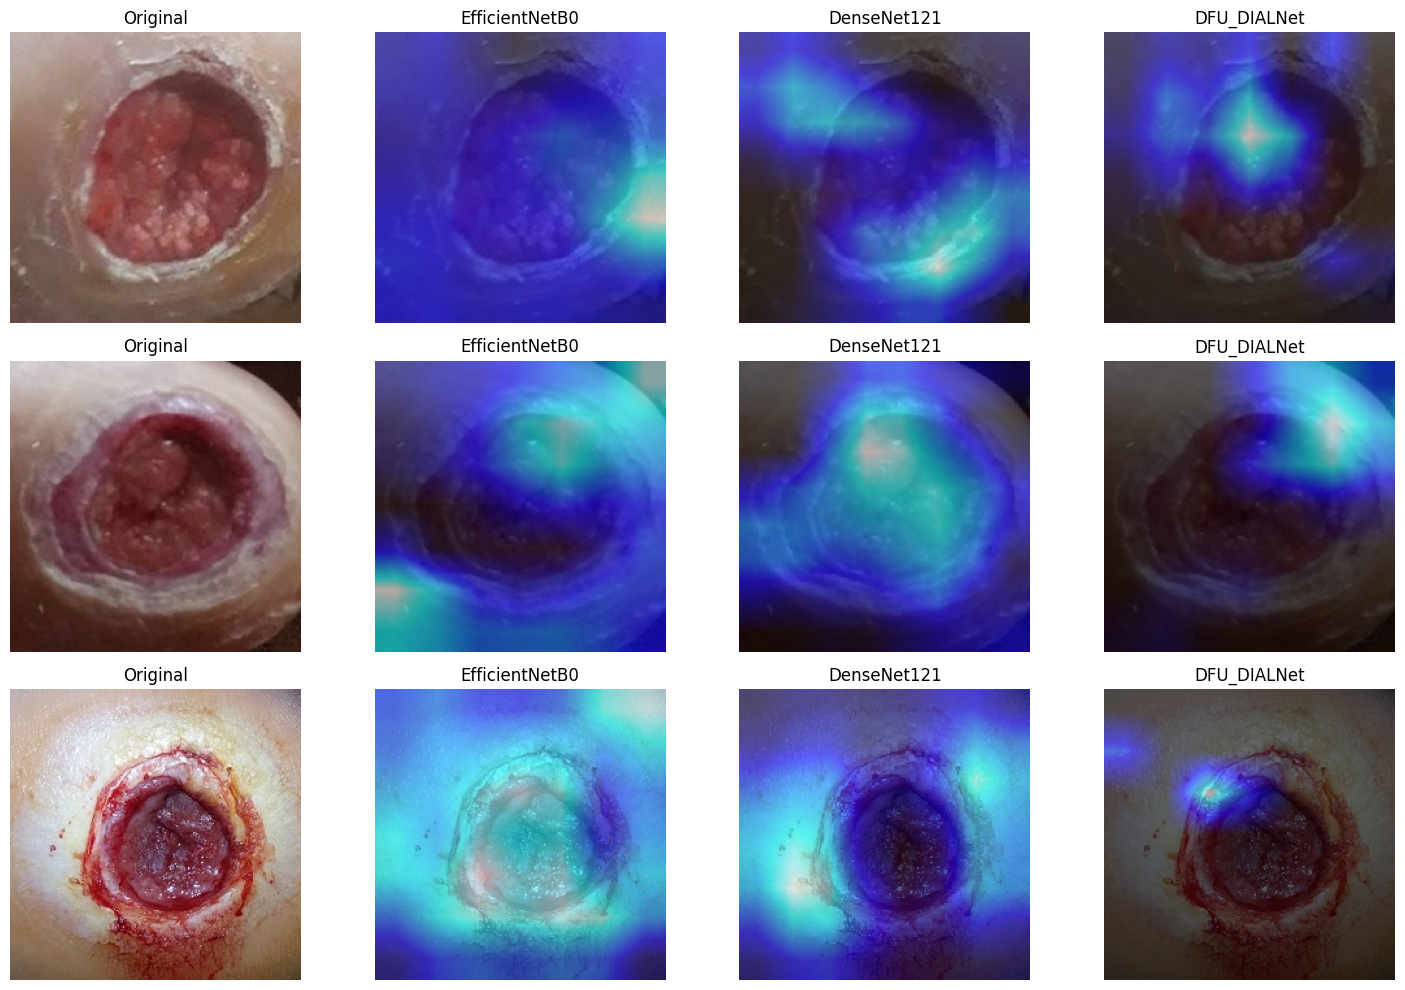

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import (
    EfficientNetB0, InceptionV3, DenseNet121
)
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_efficient
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_inception
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_densenet
import cv2

# Define Grad-CAM function
def get_gradcam(model, img_tensor, layer_name):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_tensor)
        class_index = tf.argmax(predictions[0])
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_output)
    conv_output, grads = conv_output[0], grads[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    heatmap = tf.reduce_sum(conv_output * pooled_grads, axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

# Overlay heatmap on image
def overlay_heatmap(image_rgb, heatmap, alpha=0.6, colormap=cv2.COLORMAP_HOT):
    heatmap = cv2.resize(heatmap, (image_rgb.shape[1], image_rgb.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), colormap)
    overlayed = cv2.addWeighted(image_rgb, 1 - alpha, heatmap_colored, alpha, 0)
    return overlayed

# Load and preprocess image
def load_and_preprocess(img_path, model_type):
    size = (299, 299) if model_type == 'inception' else (224, 224)
    img = image.load_img(img_path, target_size=size)
    img_rgb = image.img_to_array(img).astype(np.uint8)
    img_tensor = np.expand_dims(img_rgb, axis=0)

    if model_type == 'efficientnet':
        img_tensor = preprocess_efficient(img_tensor)
    elif model_type == 'inception':
        img_tensor = preprocess_inception(img_tensor)
    elif model_type == 'densenet':
        img_tensor = preprocess_densenet(img_tensor)

    return img_rgb, img_tensor


# List of image paths
image_paths = ["/content/22.jpg", "/content/25.jpg", "/content/29.jpg"]

# Plot Grad-CAMs
fig, axes = plt.subplots(len(image_paths), len(models) + 1, figsize=(15, 10))

for i, img_path in enumerate(image_paths):
    for j, (model_name, (model, layer_name, model_type)) in enumerate(models.items()):
        img_rgb, img_input = load_and_preprocess(img_path, model_type)
        heatmap = get_gradcam(model, img_input, layer_name)
        overlay = overlay_heatmap(img_rgb, heatmap)

        if j == 0:
            axes[i, 0].imshow(img_rgb)
            axes[i, 0].set_title("Original")
            axes[i, 0].axis('off')

        axes[i, j + 1].imshow(overlay)
        axes[i, j + 1].set_title(model_name)
        axes[i, j + 1].axis('off')

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_2459']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_2700']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_3129']]
Received: inputs=Tensor(shape=(1, 299, 299, 3))
  warnings.warn(msg)


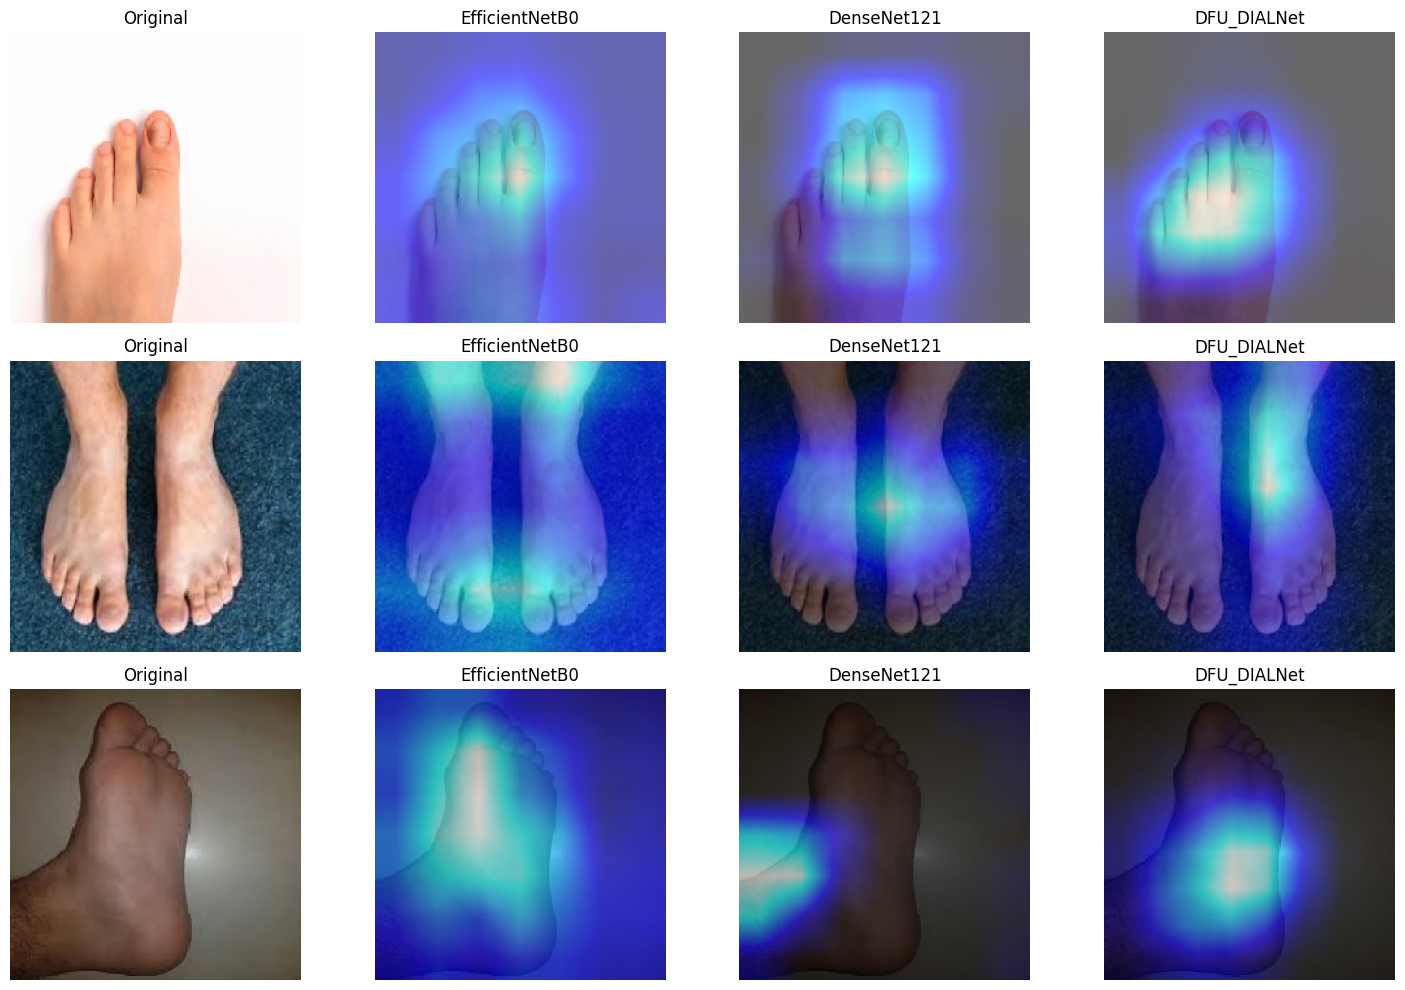

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import (
    EfficientNetB0, InceptionV3, DenseNet121
)
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_efficient
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_inception
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_densenet
import cv2

# Define Grad-CAM function
def get_gradcam(model, img_tensor, layer_name):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_tensor)
        class_index = tf.argmax(predictions[0])
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_output)
    conv_output, grads = conv_output[0], grads[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    heatmap = tf.reduce_sum(conv_output * pooled_grads, axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

# Overlay heatmap on image
def overlay_heatmap(image_rgb, heatmap, alpha=0.6, colormap=cv2.COLORMAP_HOT):
    heatmap = cv2.resize(heatmap, (image_rgb.shape[1], image_rgb.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), colormap)
    overlayed = cv2.addWeighted(image_rgb, 1 - alpha, heatmap_colored, alpha, 0)
    return overlayed

# Load and preprocess image
def load_and_preprocess(img_path, model_type):
    size = (299, 299) if model_type == 'inception' else (224, 224)
    img = image.load_img(img_path, target_size=size)
    img_rgb = image.img_to_array(img).astype(np.uint8)
    img_tensor = np.expand_dims(img_rgb, axis=0)

    if model_type == 'efficientnet':
        img_tensor = preprocess_efficient(img_tensor)
    elif model_type == 'inception':
        img_tensor = preprocess_inception(img_tensor)
    elif model_type == 'densenet':
        img_tensor = preprocess_densenet(img_tensor)

    return img_rgb, img_tensor



# List of image paths
image_paths = ["/content/16.jpg", "/content/47.png", "/content/48.jpeg"]

# Plot Grad-CAMs
fig, axes = plt.subplots(len(image_paths), len(models) + 1, figsize=(15, 10))

for i, img_path in enumerate(image_paths):
    for j, (model_name, (model, layer_name, model_type)) in enumerate(models.items()):
        img_rgb, img_input = load_and_preprocess(img_path, model_type)
        heatmap = get_gradcam(model, img_input, layer_name)
        overlay = overlay_heatmap(img_rgb, heatmap)

        if j == 0:
            axes[i, 0].imshow(img_rgb)
            axes[i, 0].set_title("Original")
            axes[i, 0].axis('off')

        axes[i, j + 1].imshow(overlay)
        axes[i, j + 1].set_title(model_name)
        axes[i, j + 1].axis('off')

plt.tight_layout()
plt.show()
